# Decoding Neural Signals with Hybrid Quantum LSTMs

## Introduction

Inspired by advances in neuroscience and related recording technology, the [Neural Latents Benchmark Challenges](https://neurallatents.github.io/) (NLB) was a Machine Learning Competition in 2021. The Challenge was won by my colleagues on the Brain-Computer-Interface team at [AE Studio](https://ae.studio/brain-computer-interface) (see [here](https://github.com/agencyenterprise/ae-nlb-2021)). 

In this project, I continue work on the NLB dataset by exploring the intersection between Hybrid Quantum ML and Neural Decoding. In particular, I use Quantum LSTM architecture to predict the hand movement of a macaque monkey, given electrophysiological measurements recorded using intracortical microelectrode arrays. 

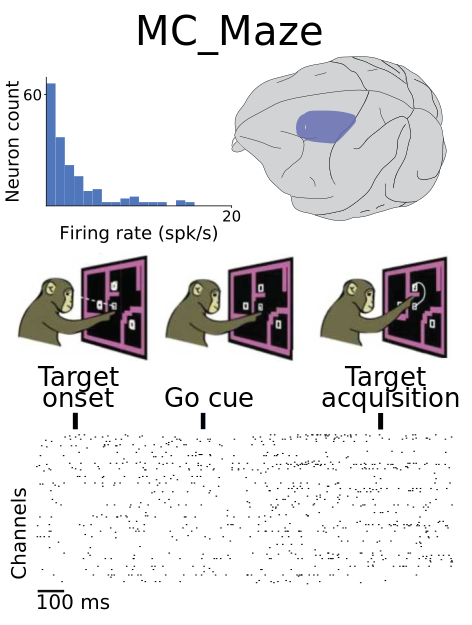

In [1]:
from IPython.display import display, Image
display(Image(filename="images/maze_fig1.png", embed=True))

## About the Data

The dataset was provided by Krishna Shenoy, Mark Churchland, and Matt Kaufman from Stanford University, and you can learn more about the task design, data collection, and their analyses of the data in a number of papers, including [this](https://pubmed.ncbi.nlm.nih.gov/21040842/) (Churchland et al. 2010). 

This project is concerned exclusively with the [MC_Maze](https://neurallatents.github.io/datasets#mcmaze) dataset. NLB provided a demo of this dataset [here](https://github.com/neurallatents/neurallatents.github.io/blob/master/notebooks/mc_maze.ipynb). In short, a monkey with a brain implant views a screen, and is instructed to move a digital cursor through a simple maze. Each electrode on the implant records neural activity, measured by proximate spikes in voltage. These spikes in activity can be used to predict the actual movement that the monkey performed.

### Download Data if necessary

In [6]:
# # Download dataset and required packages if necessary
# !pip install git+https://github.com/neurallatents/nlb_tools.git
# !pip install dandi
# !dandi download https://gui.dandiarchive.org/#/dandiset/000128
# # In the above, replace the dandiset ID with the one you want to download.
# # For convenience, I have included the smallest version of the dataset in the data folder of this repo

### Imports & Load Data

In [7]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# preprocessing
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter1d

# modelling
from torch.utils.data import DataLoader
import torch
from TSModels import SequenceDataset, ShallowRegressionLSTM, QLSTM, QShallowRegressionLSTM

# NLB specifics
from nlb_tools.nwb_interface import NWBDataset

#eval
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

In [10]:
dataset_name = "mc_maze_small" 

datanames = {
    'mc_maze' : '000128',
    'mc_maze_large' : '000138',
    'mc_maze_small' : '000140',
}
fp = f"data/{datanames[dataset_name]}/sub-Jenkins/"

In [11]:
dataset = NWBDataset(fp, 
    "*train" , split_heldout=False
    )
dataset.data.shape

(293666, 150)

## Preprocessing

The raw data measures neural spikes recorded each millisecond, but NLB suggests re-binning the data into either 5ms or 20ms bins. Here, we'll use 20ms bins. 

In [12]:
print(dataset.bin_width)
dataset.resample(20)
print(dataset.bin_width)

1
20


Additionally, we must consider the delay between neural activation, and the actual physical reaction of the monkey's hand. NLB recommends an 80ms delay, such that if a neural spike indicates hand movement, we'd expect to see the neural activity 80ms prior to when the actual movement is observed. 

In [18]:
# here, we offset our inputs and target variables with an 80ms difference
# Extract neural data and lagged hand velocity
baseline_trial_data = dataset.make_trial_data(align_field='move_onset_time', align_range=(-130, 370))
lagged_trial_data = dataset.make_trial_data(align_field='move_onset_time', align_range=(-50, 450))

# Define X and Y from these dataframes, temporarily including trial id on X
xcols = [x for x in baseline_trial_data.columns if x[0] == 'spikes']
X = baseline_trial_data[xcols+[('trial_id','')]].copy()
print(f"X shape: {X.shape}")

Y = lagged_trial_data[[('hand_vel','x'),('hand_vel','y')]].copy()
print(f"Y shape: {Y.shape}")

X shape: (2500, 143)
Y shape: (2500, 2)


The next preprocessing steps must be done after the test/train split:

In [31]:
test_pct = .3
cutoff = len(X) * (1 - test_pct)
cutoff = int(cutoff)

X_train_raw, X_test_raw = X[:cutoff].copy(), X[cutoff:].copy()
Y_train, Y_test = Y[:cutoff].copy(), Y[cutoff:].copy()

To validate that this split is valid, we ensure that no specific trial has readings on both train and test. Each trial should be exclusively in one or the other: 

In [32]:
# should be an empty set
set(X_train_raw['trial_id']).intersection(set(X_test_raw['trial_id']))

set()

In [33]:
#now we can safely drop the trial id
X_train_raw.drop(('trial_id',''), axis=1, inplace=True)
X_test_raw.drop(('trial_id',''), axis=1, inplace=True)

In [34]:
X_train_raw.shape, X_test_raw.shape, Y_train.shape, Y_test.shape

((1750, 142), (750, 142), (1750, 2), (750, 2))

Spike Data is sparse, so we reduce dimensions (after first some gaussian smoothing)

In [35]:
X_train_smth = X_train_raw.copy()
for col in X_train_raw.columns:
    X_train_smth[col] = gaussian_filter1d(X_train_raw[col].astype('float'), sigma=.5)

pca = PCA(n_components=32)
pca.fit(X_train_smth)
sum(pca.explained_variance_ratio_)

0.5788491890871712

In [36]:
X_train = pd.DataFrame(
    pca.transform(X_train_smth), 
    index=X_train_raw.index)

In [37]:
X_test_smth = X_test_raw.copy()
for col in X_test_raw.columns:
    X_test_smth[col] = gaussian_filter1d(X_test_raw[col].astype('float'), sigma=.5)
X_test = pd.DataFrame(
    pca.transform(X_test_smth),
    index=X_test_raw.index)

In [38]:
# flatten the column index for the Y data
Y_train.columns = ['hand_vel_x', 'hand_vel_y']
Y_test.columns = ['hand_vel_x', 'hand_vel_y']

In [39]:
traindf = pd.merge(X_train, Y_train, left_index=True, right_index=True)
testdf = pd.merge(X_test, Y_test, left_index=True, right_index=True)
traindf.shape, testdf.shape

((1750, 34), (750, 34))

# Modelling Helper Functions

In [40]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

# Modelling -- Classical LSTM

For simplicity I will focus on predicting just the X-dimension

In [41]:
torch.manual_seed(101)
batch_size = 1
sequence_length = 4

target = 'hand_vel_x'
features = [x for x in traindf.columns if x not in ('hand_vel_x', 'hand_vel_y')]

train_dataset = SequenceDataset(
    traindf,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    testdf,
    target=target,
    features=features,
    sequence_length=sequence_length
)

In [42]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1, 4, 32])
Target shape: torch.Size([1])


In [43]:
# in general, parameters are chosen to be equivalent to what 
# is used in the Quantum version later in this notebook, to provide a fair comparison
learning_rate = 0.0005
num_hidden_units = 32

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [44]:
classical_loss_train = []
classical_loss_test = []
print("Untrained test\n--------")
test_loss = test_model(test_loader, model, loss_function)

classical_loss_test.append(test_loss)
epochs = 25
for ix_epoch in range(epochs):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, model, loss_function)
    print()
    classical_loss_train.append(train_loss)
    classical_loss_test.append(test_loss)

Untrained test
--------
Test loss: 114160.53642058306
Epoch 0
---------
Train loss: 130378.57366034169
Test loss: 110859.39135617508

Epoch 1
---------
Train loss: 125118.93653279635
Test loss: 106047.0788217405

Epoch 2
---------
Train loss: 120409.41739426952
Test loss: 103203.09120832666

Epoch 3
---------
Train loss: 116417.85308047588
Test loss: 99356.09371339042

Epoch 4
---------
Train loss: 112747.31309920293
Test loss: 96673.44096601162

Epoch 5
---------
Train loss: 109392.02797662861
Test loss: 94121.6167168892

Epoch 6
---------
Train loss: 106334.06143717364
Test loss: 91791.32672789694

Epoch 7
---------
Train loss: 103487.38814942417
Test loss: 89605.86404712884

Epoch 8
---------
Train loss: 100628.74575336334
Test loss: 87043.43139300769

Epoch 9
---------
Train loss: 97058.67648787795
Test loss: 84182.9813580632

Epoch 10
---------
Train loss: 93451.01476173195
Test loss: 83351.02042903936

Epoch 11
---------
Train loss: 89721.08948716373
Test loss: 79819.16539167879


In [67]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = ("Model forecast",'')
traindf[ystar_col] = predict(train_eval_loader, model).numpy()
testdf[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((traindf, testdf))[[target, ystar_col]]

### Evaluating the Classical Model

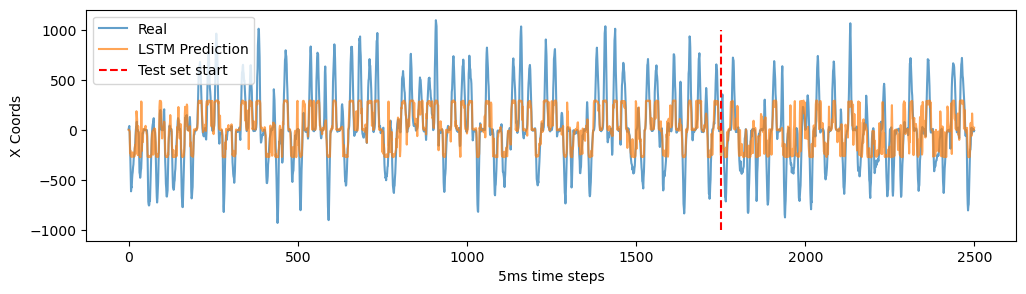

In [70]:
plt.figure(figsize=(12, 3))
plt.plot(range(len(df_out)), df_out[target], label = "Real", alpha = .7)
plt.plot(range(len(df_out)), df_out[ystar_col], label = "LSTM Prediction", alpha = .7)
plt.ylabel('X Coords')
plt.xlabel('5ms time steps')
plt.vlines(len(df_out) * (1 - test_pct), ymin = -1000, ymax = 1000, label = "Test set start", linestyles = "dashed",
          colors = "red")
plt.legend()
plt.show()

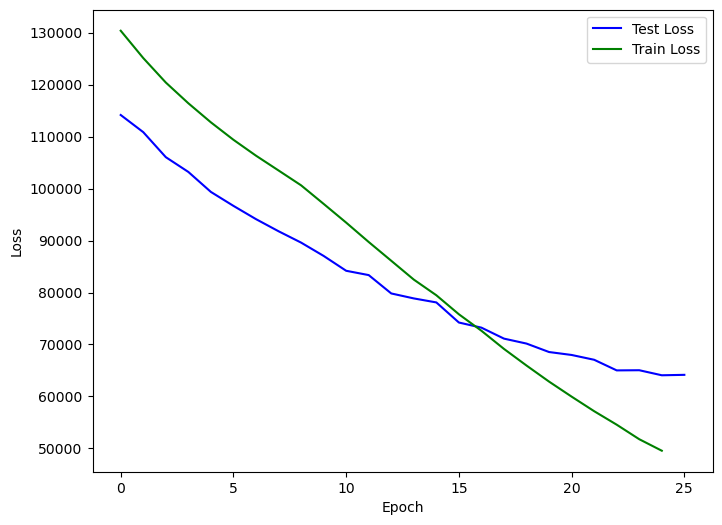

In [73]:
plt.figure(figsize=(8, 6))
plt.plot(range(len(classical_loss_test)), classical_loss_test, color = "blue")
plt.plot(range(len(classical_loss_train)), classical_loss_train, color = "green")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(["Test Loss", "Train Loss"])
plt.show()

In [77]:
r2 = r2_score(df_out[target], df_out[ystar_col])
corr, _ = pearsonr(testdf[target], testdf[ystar_col])

print(f"R2: {round(r2,2)}")
print(f"Pearson correlation: {round(corr,2)}")

R2: 0.58
Pearson correlation: 0.66


# Modelling -- Quantum LSTM

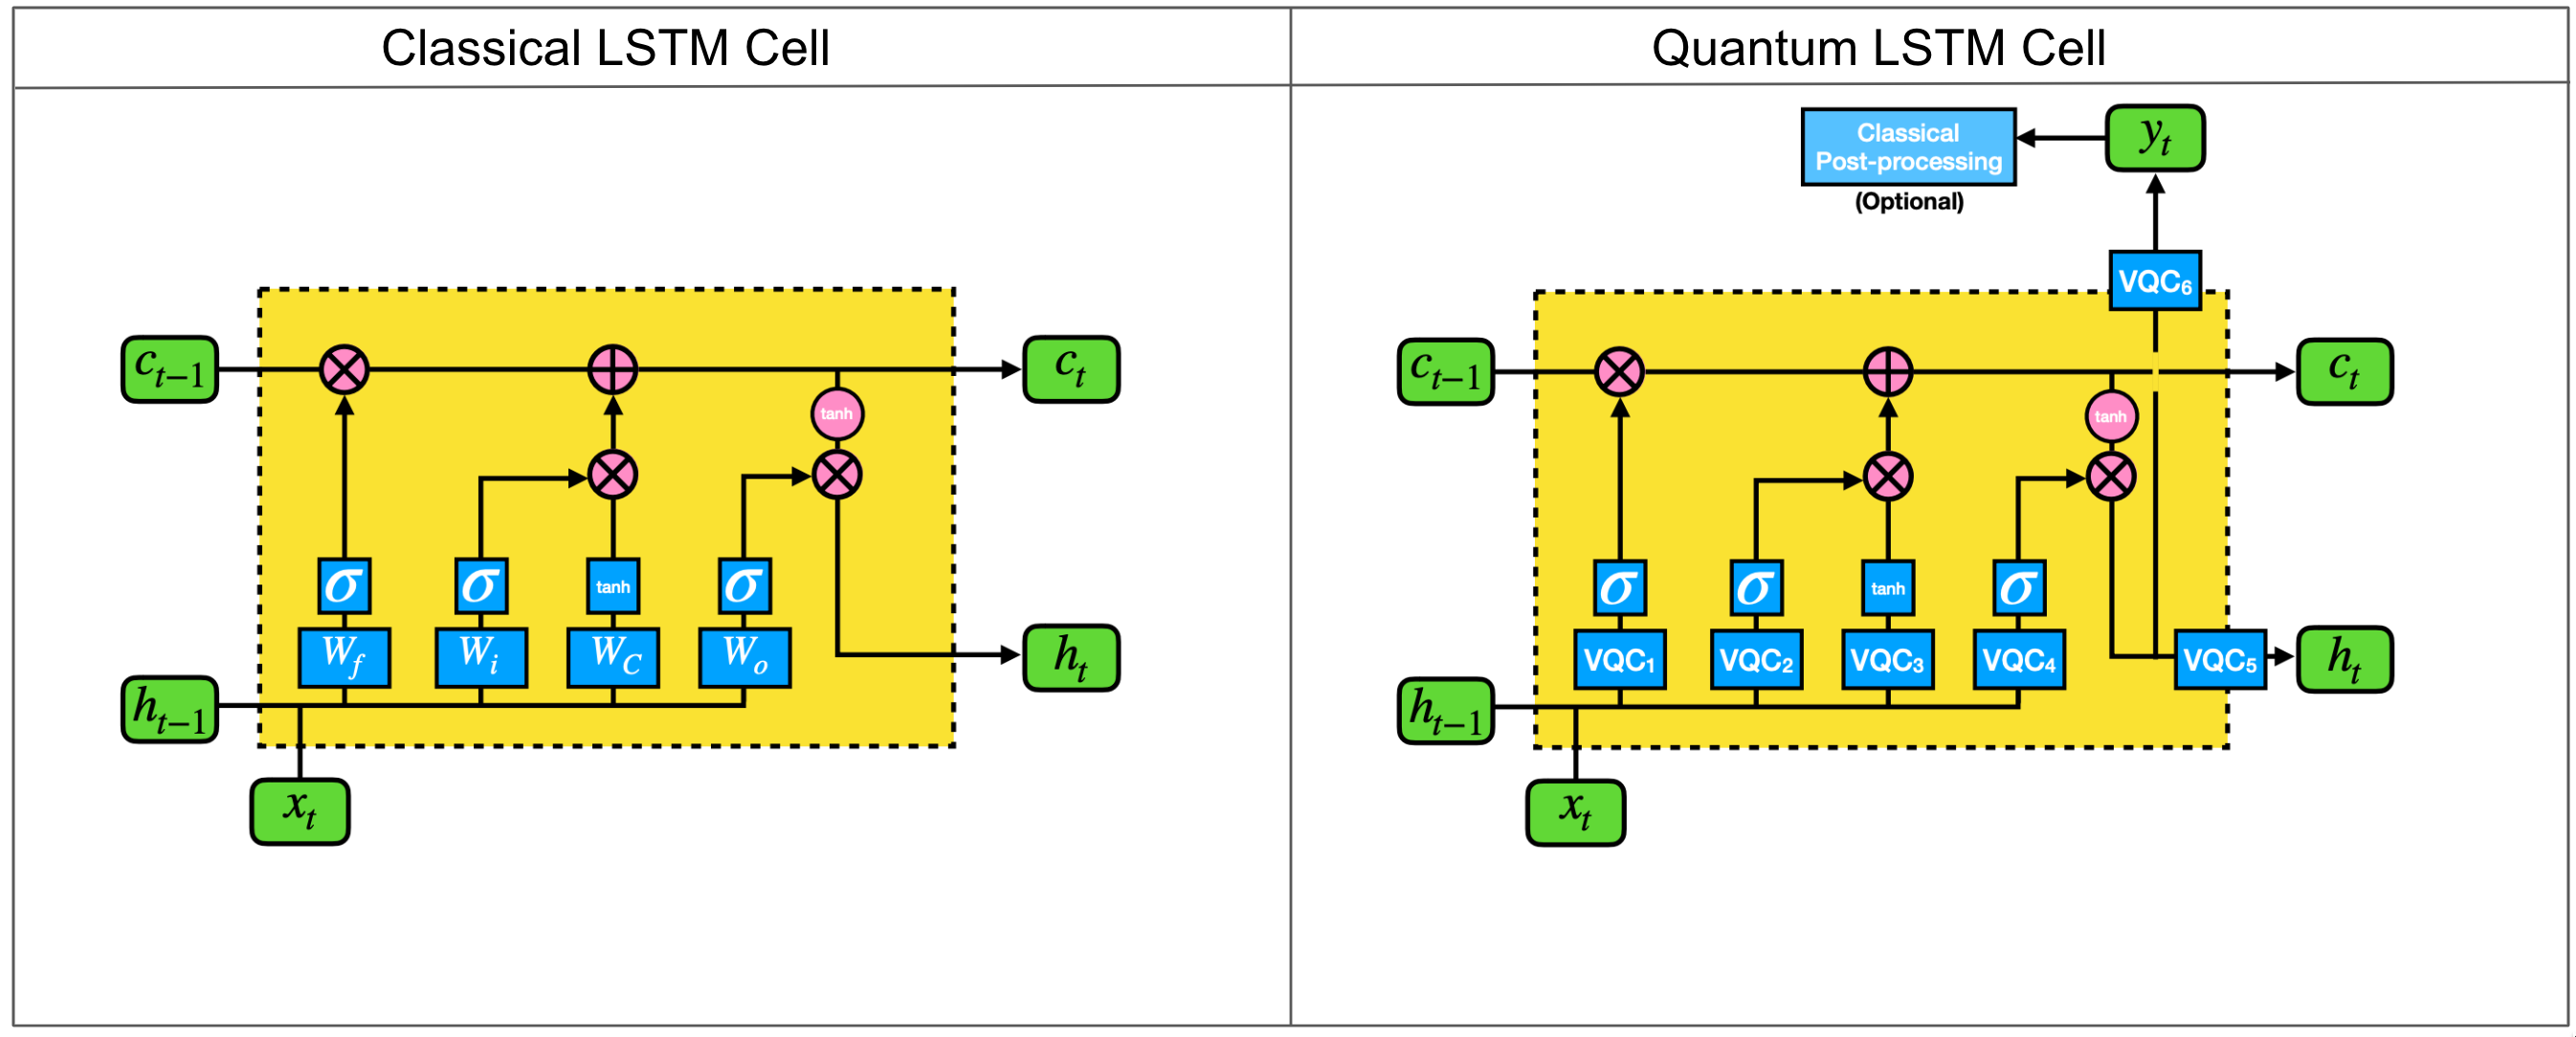

In [78]:
display(Image(filename='images/LSTM-diagram.png'))

*Image credit to Samuel Yen-Chi Chen, Shinjae Yoo, Yao-Lung L. Fang (https://arxiv.org/abs/2009.01783)*